# Scheduling Multipurpose Batch Processes using State-Task Networks
## By Pete Giannini and Noah Wamble 

Keywords:state-task networks, gdp, disjunctive programming, batch processes

The State-Task Network (STN) is an approach to modeling multipurpose batch process for the purpose of short term scheduling. It was first developed by Kondili, et al., in 1993, and subsequently developed and extended by others. This notebook will look at scheduling jobs in a small craft brewery. 


## Imports

In [1]:
!conda install -c conda-forge ipopt glpk
# !conda install -c conda-forge coincbc 

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
    
import shutil
import sys
import os.path

from pyomo.environ import *

## Example (Kondili, et al., 1993)

A state-task network is a graphical representation of the activities in a multiproduct batch process. The representation includes the minimum details needed for short term scheduling of batch operations.

A well-studied example due to Kondili (1993) is shown below. Other examples are available in the references cited above.

![Kondili_1993.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/Kondili_1993.png?raw=1)

Each circular node in the diagram designates material in a particular state.  The materials are generally held in suitable vessels with a known capacity. The relevant information for each state is the initial inventory, storage capacity, and the unit price of the material in each state. The price of materials in intermediate states may be assigned penalities in order to minimize the amount of work in progress.

The rectangular nodes denote process tasks. When scheduled for execution, each task is assigned an appropriate piece of equipment, and assigned a batch of material according to the incoming arcs. Each incoming arc begins at a state where the associated label indicates the mass fraction of the batch coming from that particular state. Outgoing arcs indicate the disposition of the batch to product states. The outgoing are labels indicate the fraction of the batch assigned to each product state, and the time necessary to produce that product. 

Not shown in the diagram is the process equipment used to execute the tasks. A separate list of process units is available, each characterized by a capacity and list of tasks which can be performed in that unit.

## Encoding the STN data

The basic data structure specifies the states, tasks, and units comprising a state-task network. The intention is for all relevant problem data to be contained in a single JSON-like structure.

In [3]:
# planning horizon
H = 10

Kondili = {
    # time grid
    'TIME':  range(0, H+1),
    
    # states
    'STATES': {
        'Feed_A'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Feed_B'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Feed_C'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Hot_A'    : {'capacity': 100, 'initial':   0, 'price': -100},
        'Int_AB'   : {'capacity': 200, 'initial':   0, 'price': -100},
        'Int_BC'   : {'capacity': 150, 'initial':   0, 'price': -100},
        'Impure_E' : {'capacity': 100, 'initial':   0, 'price': -100},
        'Product_1': {'capacity': 500, 'initial':   0, 'price': 10},
        'Product_2': {'capacity': 500, 'initial':   0, 'price': 10},
    },
    
    # state-to-task arcs indexed by (state, task)
    'ST_ARCS': {
        ('Feed_A',   'Heating')   : {'rho': 1.0},
        ('Feed_B',   'Reaction_1'): {'rho': 0.5},
        ('Feed_C',   'Reaction_1'): {'rho': 0.5},
        ('Feed_C',   'Reaction_3'): {'rho': 0.2},
        ('Hot_A',    'Reaction_2'): {'rho': 0.4},
        ('Int_AB',   'Reaction_3'): {'rho': 0.8},
        ('Int_BC',   'Reaction_2'): {'rho': 0.6},
        ('Impure_E', 'Separation'): {'rho': 1.0},
    },
    
    # task-to-state arcs indexed by (task, state)
    'TS_ARCS': {
        ('Heating',    'Hot_A')    : {'dur': 1, 'rho': 1.0},
        ('Reaction_2', 'Product_1'): {'dur': 2, 'rho': 0.4},
        ('Reaction_2', 'Int_AB')   : {'dur': 2, 'rho': 0.6},
        ('Reaction_1', 'Int_BC')   : {'dur': 2, 'rho': 1.0},
        ('Reaction_3', 'Impure_E') : {'dur': 1, 'rho': 1.0},
        ('Separation', 'Int_AB')   : {'dur': 2, 'rho': 0.1},
        ('Separation', 'Product_2'): {'dur': 1, 'rho': 0.9},
    },
    
    # unit data indexed by (unit, task)
    'UNIT_TASKS': {
        ('Heater',    'Heating')   : {'Bmin': 0, 'Bmax': 100, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_1'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_2'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_3'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_1'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_2'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_3'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Still',     'Separation'): {'Bmin': 0, 'Bmax': 200, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
    },
}

STN = Kondili

In [49]:
#Planning horizon 
H=10

brewery = {
    # time grid
    'TIME':  range(0, H+1),
    
    # states
    'STATES': {
        #main feeds 
        'Feed_A'   : {'capacity': 500, 'initial': 1000, 'price':  0},
        'Feed_B'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'mash'    : {'capacity': 500, 'initial':   0, 'price': 0},
        'husk'   : {'capacity': 500, 'initial':   0, 'price': 0},
        
        #this is the liquid after the lautering step 
        'wort'   : {'capacity': 500, 'initial':   0, 'price': -50},
        
        #this is the wort after the boiling step 
        'wort_heated': {'capacity': 500, 'initial': 0, 'price': -50},
        
        #this is after the separation step 
        'wort_separated' : {'capacity': 500, 'initial': 0, 'price': -50},
        
        #this is the waste product from the separator 
        'malt' : {'capacity': 500, 'initial':   0, 'price': -50},
        
        #brights 
        'bright_A': {'capacity': 500, 'initial':   0, 'price': -50},
        'bright_B': {'capacity': 550, 'initial':   0, 'price': -50},
        'bright_C': {'capacity': 400, 'initial':   0, 'price': -50},
        
        #state before canning/kegging 
#         'pre_packaged_A': {'capacity': 500, 'initial':   0, 'price': -150},
#         'pre_packaged_B': {'capacity': 500, 'initial':   0, 'price': -150},
#         'pre_packaged_C': {'capacity': 500, 'initial':   0, 'price': -150},

        
#         #final product 
        'canned_A': {'capacity': 500, 'initial':   0, 'price': 300},
        'canned_B': {'capacity': 500, 'initial':   0, 'price': 400},
        'canned_C': {'capacity': 500, 'initial':   0, 'price': 500},
        'keg_A': {'capacity': 500, 'initial':   0, 'price': 1000},
        'keg_B': {'capacity': 500, 'initial':   0, 'price': 900},
        'keg_C': {'capacity': 500, 'initial':   0, 'price': 800},

    },
    
    # state-to-task arcs indexed by (state, task)
    'ST_ARCS': {
        ('Feed_A',   'Heating_conversion')   : {'rho': 1.0},
        ('Feed_B',   'kettle'): {'rho': 0.5},
        ('mash',   'lautering'): {'rho': 1},
        ('wort',   'kettle'): {'rho': 0.5},
        ('wort_heated', 'separator'): {'rho': 1},
        ('wort_separated',    'Reaction_A'): {'rho': 1},
        ('wort_separated',    'Reaction_B'): {'rho': 1},
        ('wort_separated',    'Reaction_C'): {'rho': 1},

        #we want it such that any product can go into any bright tank as it is just a holding tank 
        ('bright_A',    'can_line_A'): {'rho': 1},
        ('bright_B',    'can_line_B'): {'rho': 1},
        ('bright_C',    'can_line_C'): {'rho': 1},
#         ('pre_packaged_A',    'can_line'): {'rho': 0.4},
#         ('pre_packaged_B',    'can_line'): {'rho': 0.4},
#         ('pre_packaged_C',    'can_line'): {'rho': 0.4},
        ('bright_A',    'keg_line_A'): {'rho': 1},
        ('bright_B',    'keg_line_B'): {'rho': 1},
        ('bright_C',    'keg_line_C'): {'rho': 1},  
    },
    
    # task-to-state arcs indexed by (task, state)
    'TS_ARCS': {
       #preparation of pre-fermentated mix 
        ('Heating_conversion',    'mash')    : {'dur': 1, 'rho': 1.0},
        #for one gram of mash 20% of it goes to waste, while 80% of it continues along in process 
        ('lautering', 'wort'): {'dur': 1, 'rho': 0.8},
        ('lautering', 'husk'): {'dur': 1, 'rho': 0.2},
        ('kettle', 'wort_heated')   : {'dur': 1, 'rho': 1},
        #15% of what enters the separator goes to waste, the rest continues on 
        ('separator', 'wort_separated'): {'dur': 1, 'rho': .85},
        ('separator', 'malt')   : {'dur': 1, 'rho': 0.15},
        
        #fermentation 
        ('Reaction_A', 'bright_A')   : {'dur': 1, 'rho': 1.0},
        ('Reaction_B', 'bright_B') : {'dur': 1, 'rho': 1.0},
        ('Reaction_C', 'bright_C') : {'dur': 1, 'rho': 1.0},
#         #holding tank 
#         ('bright_holding_A', 'pre_packaged_A'): {'dur': .1, 'rho': 1},
#         ('bright_holding_B', 'pre_packaged_B'): {'dur': .1, 'rho': 1},
#         ('bright_holding_C', 'pre_packaged_C'): {'dur': .1, 'rho': 1},
#         #canning operation 
        ('can_line_A', 'canned_A')   : {'dur': 1, 'rho': 1},
        ('can_line_B', 'canned_B')   : {'dur': 1, 'rho': 1},
        ('can_line_C', 'canned_C')   : {'dur': 1, 'rho': 1},
        #Kegging operationg 
        ('keg_line_C', 'keg_C')   : {'dur': 1, 'rho': 1},
        ('keg_line_B', 'keg_B')   : {'dur': 1, 'rho': 1},
        ('keg_line_A', 'keg_A')   : {'dur': 1, 'rho': 1},
    },
    
    # unit data indexed by (unit, task)
    'UNIT_TASKS': {
        ('Heater',    'Heating_conversion')   : {'Bmin': 0, 'Bmax': 550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Lauter', 'lautering'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Kettle_drum', 'kettle'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Separator_tank', 'separator'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
       
        
        #this fermenter can do any of the fermentation reactions 
        ('Fermenter_1', 'Reaction_A'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Fermenter_1', 'Reaction_B'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Fermenter_1', 'Reaction_C'): {'Bmin': 0, 'Bmax':  550, 'Cost': 1, 'vCost': 0, 'Tclean': 0},

        #this fermenter can do any of the fermentation reactions 
#         ('Fermenter_2', 'Reaction_A'): {'Bmin': 0, 'Bmax':  550, 'Cost': 100, 'vCost': 0, 'Tclean': 0},       
#         ('Fermenter_2', 'Reaction_B'): {'Bmin': 0, 'Bmax':  550, 'Cost': 100, 'vCost': 0, 'Tclean': 0},
#         ('Fermenter_2', 'Reaction_C'): {'Bmin': 0, 'Bmax':  550, 'Cost': 100, 'vCost': 0, 'Tclean': 0},

        #doesnt like the bright tank for some reason
#         #bright from any reaction can be put in any bright tank 
#         ('bright_tank1', 'bright_holding_A'): {'Bmin': 10, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
#         ('bright_tank1', 'bright_holding_B'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
#         ('bright_tank1', 'bright_holding_C'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
#         ('bright_tank2', 'bright_holding_A'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
#         ('bright_tank2', 'bright_holding_B'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
#         ('bright_tank2', 'bright_holding_C'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        
#         #there is only one keg line and only one can line 
        ('canner', 'can_line_A'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},
        ('canner', 'can_line_B'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},
        ('canner', 'can_line_C'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},

        ('kegger', 'keg_line_A'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},
        ('kegger', 'keg_line_B'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},
        ('kegger', 'keg_line_C'): {'Bmin': 0, 'Bmax':  550, 'Cost': 5, 'vCost': 0, 'Tclean': 0},


        
    },
}
STN= brewery

### Setting a time grid

The following computations can be done on any time grid, including real-valued time points. TIME is a list of time points commencing at 0.

## Creating a Pyomo model

The following Pyomo model closely follows the development in Kondili, et al. (1993). In particular, the first step in the model is to process the STN data to create sets as given in Kondili.  

One important difference from Kondili is the adoption of a more natural time scale that starts at $t = 0$ and extends to $t = H$ (rather than from 1 to H+1).

A second difference is the introduction of an additional decision variable denoted by $Q_{j,t}$ indicating the amount of material in unit $j$ at time $t$. A material balance then reads

\begin{align*}
Q_{jt} & = Q_{j(t-1)} + \sum_{i\in I_j}B_{ijt} - \sum_{i\in I_j}\sum_{\substack{s \in \bar{S}_i\\s\ni t-P_{is} \geq 0}}\bar{\rho}_{is}B_{ij(t-P_{is})} \qquad \forall j,t
\end{align*}

Following Kondili's notation, $I_j$ is the set of tasks that can be performed in unit $j$, and $\bar{S}_i$ is the set of states fed by task $j$. We assume the units are empty at the beginning and end of production period, i.e.,

\begin{align*}
Q_{j(-1)} & = 0 \qquad \forall j \\
Q_{j,H} & = 0 \qquad \forall j
\end{align*}

The unit allocation constraints are written the full backward aggregation method described by Shah (1993).  The allocation constraint reads

\begin{align*}
\sum_{i \in I_j} \sum_{t'=t}^{t-p_i+1} W_{ijt'} & \leq 1 \qquad \forall j,t
\end{align*}

Each processing unit $j$ is tagged with a minimum and maximum capacity, $B_{ij}^{min}$ and $B_{ij}^{max}$, respectively, denoting the minimum and maximum batch sizes for each task $i$. A minimum capacity may be needed to cover heat exchange coils in a reactor or mixing blades in a blender, for example. The capacity may depend on the nature of the task being performed.  These constraints are written

\begin{align*}
B_{ij}^{min}W_{ijt} & \leq B_{ijt} \leq  B_{ij}^{max}W_{ijt} \qquad \forall j, \forall i\in I_j, \forall t
\end{align*}

### Characterization of tasks

In [50]:
STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)
# print(STATES)
# print(ST_ARCS)
# print(TS_ARCS)

In [51]:
# set of tasks
TASKS = set([i for (j,i) in UNIT_TASKS])

# S[i] input set of states which feed task i
S = {i: set() for i in TASKS}
for (s,i) in ST_ARCS:
    S[i].add(s)

# S_[i] output set of states fed by task i
S_ = {i: set() for i in TASKS}
for (i,s) in TS_ARCS:
    S_[i].add(s)

# rho[(i,s)] input fraction of task i from state s
rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}

# rho_[(i,s)] output fraction of task i to state s
rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}

# P[(i,s)] time for task i output to state s 
P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}

# p[i] completion time for task i
p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}

# K[i] set of units capable of task i
K = {i: set() for i in TASKS}
for (j,i) in UNIT_TASKS:
    K[i].add(j) 

### Characterization of states

In [52]:
# T[s] set of tasks receiving material from state s
T = {s: set() for s in STATES}

for (s,i) in ST_ARCS:
    T[s].add(i)

# set of tasks producing material for state s
T_ = {s: set() for s in STATES}
for (i,s) in TS_ARCS:
    T_[s].add(i)

# C[s] storage capacity for state s
C = {s: STATES[s]['capacity'] for s in STATES}

### Characterization of units

In [53]:
UNITS = set([j for (j,i) in UNIT_TASKS])

# I[j] set of tasks performed with unit j
I = {j: set() for j in UNITS}
for (j,i) in UNIT_TASKS:
    I[j].add(i)

# Bmax[(i,j)] maximum capacity of unit j for task i
Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}

# Bmin[(i,j)] minimum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}

### Pyomo model

In [54]:
TIME = np.array(TIME)

model = ConcreteModel('Brewery Optimization')

# W[i,j,t] 1 if task i starts in unit j at time t
model.W = Var(TASKS, UNITS, TIME, domain=Boolean)

# B[i,j,t,] size of batch assigned to task i in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)

# S[s,t] inventory of state s at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)

# Q[j,t] inventory of unit j at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)

# Objective function

# project value
model.Value = Var(domain=NonNegativeReals)
model.valuec = Constraint(expr = model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES]))

# project cost
model.Cost = Var(domain=NonNegativeReals)
model.costc = Constraint(expr = model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

model.obj = Objective(expr = model.Value - model.Cost, sense = maximize)
# model.obj = Objective(expr = sum(model.S['keg_C',t] + model.S['keg_B',t] + model.S['keg_C',t] for t in TIME), sense = maximize)
# model.obj = Objective(expr = sum(model.S['keg_A',t] for t in TIME), sense = maximize)

# model.S.pprint()
# input()

# model.obj= Objective(expr= model.S['Feed_A',5] + model.S['Feed_B',5] + model.S['wort', 5], sense= minimize)
# model.obj= Objective(expr= model.S['Feed_B',5] + model.S['wort', 5], sense= minimize)


# Constraints
model.cons = ConstraintList()

# a unit can only be allocated to one task 
for j in UNITS:
    for t in TIME:
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)
#         model.cons.pprint()
    
# state capacity constraint
model.sc = Constraint(STATES.keys(), TIME, rule = lambda model, s, t: model.S[s,t] <= C[s])

# state mass balances
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
    
# unit capacity constraints
for t in TIME:
    for j in UNITS:
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j]) 

# unit mass balances
for j in UNITS:
    rhs = 0
    for t in TIME:
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]

# unit terminal condition
model.tc = Constraint(UNITS, rule = lambda model, j: model.Q[j,H] == 0)

SolverFactory('glpk').solve(model).write()
# model.pprint()
# print(model.Value())
# print(model.Cost())
# print(model.obj())
# model.pprint()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 807480.0
  Upper bound: 807480.0
  Number of objectives: 1
  Number of constraints: 824
  Number of variables: 553
  Number of nonzeros: 2006
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 21111
      Number of created subproblems: 21111
  Error rc: 0
  Time: 11.767534017562866
# ----------------------------------------------------------
#   Solution Information
# -----------------

## Analysis

### Profitability



In [55]:
# model.valuec.pprint()
# model.costc.pprint()
print("Value of State Inventories = {0:12.2f}".format(model.Value()))
print("  Cost of Unit Assignments = {0:12.2f}".format(model.Cost()))
print("             Net Objective = {0:12.2f}".format(model.Value() - model.Cost()))

Value of State Inventories =    807500.00
  Cost of Unit Assignments =        20.00
             Net Objective =    807480.00


### Unit assignment

In [56]:
UnitAssignment = pd.DataFrame({j:[None for t in TIME] for j in UNITS}, index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t-p[i] >= 0:
                    if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                        UnitAssignment.loc[t,j] = None               
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                UnitAssignment.loc[t,j] = (i,model.B[i,j,t]())

UnitAssignment

,canner,Heater,Kettle_drum,Lauter,Fermenter_1,kegger,Separator_tank
0,None,"(Heating_conversion, 550.0)",None,None,None,None,None
1,None,"(Heating_conversion, 75.0)",None,"(lautering, 550.0)",None,None,None
2,None,None,None,None,None,None,None
3,None,None,"(kettle, 450.0)",None,None,None,None
4,None,None,None,"(lautering, 75.0)",None,None,"(separator, 450.0)"
5,None,None,"(kettle, 550.0)",None,None,None,None
6,None,None,None,None,"(Reaction_B, 350.0)",None,"(separator, 550.0)"
7,None,None,None,None,"(Reaction_A, 500.0)",None,None
8,None,None,None,None,None,"(keg_line_A, 500.0)",None
9,None,None,None,None,None,"(keg_line_B, 350.0)",None


### State inventories

In [57]:
pd.DataFrame([[model.S[s,t]() for s in STATES.keys()] for t in TIME], columns = STATES.keys(), index = TIME)

,Feed_A,Feed_B,mash,husk,wort,wort_heated,wort_separated,malt,bright_A,bright_B,bright_C,canned_A,canned_B,canned_C,keg_A,keg_B,keg_C
0,450.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,375.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,375.0,500.0,75.0,110.0,440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,375.0,275.0,75.0,110.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,375.0,275.0,0.0,110.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,375.0,0.0,0.0,125.0,0.0,0.0,382.5,67.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,375.0,0.0,0.0,125.0,0.0,0.0,32.5,67.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,375.0,0.0,0.0,125.0,0.0,0.0,0.0,150.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,375.0,0.0,0.0,125.0,0.0,0.0,0.0,150.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,375.0,0.0,0.0,125.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0


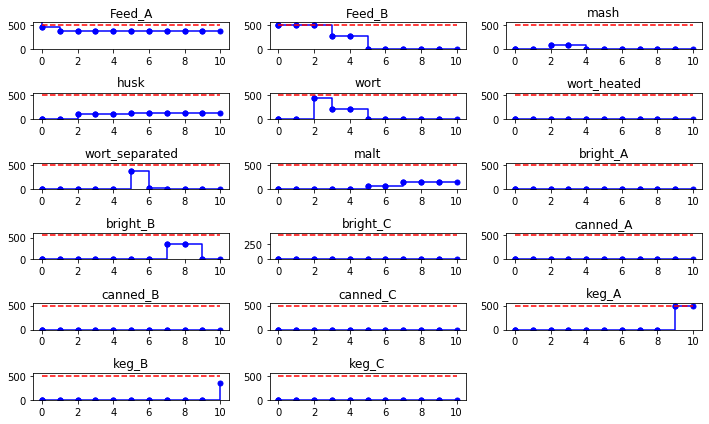

In [60]:
plt.figure(figsize=(10,6))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Unit batch inventories

In [61]:
pd.DataFrame([[model.Q[j,t]() for j in UNITS] for t in TIME], columns = UNITS, index = TIME)

,canner,Heater,Kettle_drum,Lauter,Fermenter_1,kegger,Separator_tank
0,0.0,550.0,0.0,0.0,0.0,0.0,0.0
1,0.0,75.0,0.0,550.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,450.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,75.0,0.0,0.0,450.0
5,0.0,0.0,550.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,350.0,0.0,550.0
7,0.0,0.0,0.0,0.0,500.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,500.0,0.0
9,0.0,0.0,0.0,0.0,0.0,350.0,0.0


### Gannt chart

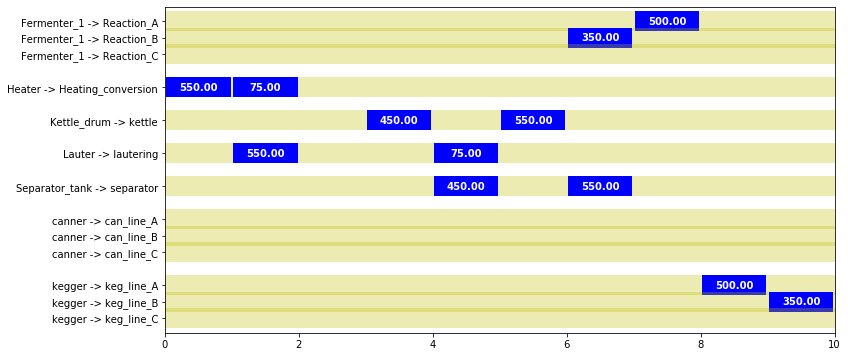

In [62]:
plt.figure(figsize=(12,6))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.2f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

## Trace of events and states

In [63]:
sep = '\n--------------------------------------------------------------------------------------------\n'
print(sep)
print("Starting Conditions")
print("    Initial Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,STATES[s]['initial']))
        
units = {j:{'assignment':'None', 't':0} for j in UNITS}

for t in TIME:
    print(sep)
    print("Time =",t,"hr")
    print("    Instructions:")
    for j in UNITS:
        units[j]['t'] += 1
        # transfer from unit to states
        for i in I[j]:  
            for s in S_[i]:
                if t-P[(i,s)] >= 0:
                    amt = rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t - P[(i,s)]])]()
                    if amt > 0:
                        print("        Transfer", amt, "kg from", j, "to", s)
    for j in UNITS:
        # release units from tasks
        for i in I[j]:
            if t-p[i] >= 0:
                if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                    print("        Release", j, "from", i)
                    units[j]['assignment'] = 'None'
                    units[j]['t'] = 0
        # assign units to tasks             
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                print("        Assign", j, "with capacity", Bmax[(i,j)], "kg to task",i,"for",p[i],"hours")
                units[j]['assignment'] = i
                units[j]['t'] = 1
        # transfer from states to starting tasks
        for i in I[j]:
            for s in S[i]:
                amt = rho[(i,s)]*model.B[i,j,t]()
                if amt > 0:
                    print("        Transfer", amt,"kg from", s, "to", j)
    print("\n    Inventories are now:")            
    for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,t]()))
    print("\n    Unit Assignments are now:")
    for j in UNITS:
        if units[j]['assignment'] != 'None':
            fmt = "        {0:s} performs the {1:s} task with a {2:.2f} kg batch for hour {3:f} of {4:f}"
            i = units[j]['assignment']
            print(fmt.format(j,i,model.Q[j,t](),units[j]['t'],p[i]))
            
print(sep)
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,H]()))


--------------------------------------------------------------------------------------------

Starting Conditions
    Initial Inventories:
        Feed_A      1000.0 kg
        Feed_B       500.0 kg
        mash           0.0 kg
        husk           0.0 kg
        wort           0.0 kg
        wort_heated     0.0 kg
        wort_separated     0.0 kg
        malt           0.0 kg
        bright_A       0.0 kg
        bright_B       0.0 kg
        bright_C       0.0 kg
        canned_A       0.0 kg
        canned_B       0.0 kg
        canned_C       0.0 kg
        keg_A          0.0 kg
        keg_B          0.0 kg
        keg_C          0.0 kg

--------------------------------------------------------------------------------------------

Time = 0 hr
    Instructions:
        Assign Heater with capacity 550 kg to task Heating_conversion for 1 hours
        Transfer 550.0 kg from Feed_A to Heater

    Inventories are now:
        Feed_A       450.0 kg
        Feed_B       500.0 kg
    

## References

Floudas, C. A., & Lin, X. (2005). Mixed integer linear programming in process scheduling: Modeling, algorithms, and applications. Annals of Operations Research, 139(1), 131-162.

Harjunkoski, I., Maravelias, C. T., Bongers, P., Castro, P. M., Engell, S., Grossmann, I. E., ... & Wassick, J. (2014). Scope for industrial applications of production scheduling models and solution methods. Computers & Chemical Engineering, 62, 161-193.

Kondili, E., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—I. MILP formulation. Computers & Chemical Engineering, 17(2), 211-227.

Méndez, C. A., Cerdá, J., Grossmann, I. E., Harjunkoski, I., & Fahl, M. (2006). State-of-the-art review of optimization methods for short-term scheduling of batch processes. Computers & Chemical Engineering, 30(6), 913-946.

Shah, N., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—II. Computational issues. Computers & Chemical Engineering, 17(2), 229-244.

Wassick, J. M., & Ferrio, J. (2011). Extending the resource task network for industrial applications. Computers & chemical engineering, 35(10), 2124-2140.